In [9]:
# Set up the Training dataset class, convert the fluorescent images and labeled images 
# generated by the MATLAB code to training dataset that Mask RCNN can recognize.

import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import cv2

class FluorescentDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        """
        Args:
            folder_path (str): Path to the folder containing the fluorescent and mask images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.folder_path = folder_path
        self.transform = transform
        
        # Collect image and corresponding mask paths
        self.image_paths = sorted([os.path.join(folder_path, f) 
                                   for f in os.listdir(folder_path) 
                                   if f.startswith('fluo') and f.endswith('.png')])
        
        self.mask_paths = [os.path.join(folder_path, self.replace_fluo_with_label(os.path.basename(image_path))) 
                           for image_path in self.image_paths]
    def replace_fluo_with_label(self, image_filename):
        """Replace 'fluo' with 'label_fluo' in the filename."""
        return image_filename.replace('fluo', 'label_fluo')
        
    def __len__(self):
        return len(self.image_paths)
        
    def create_binary_masks(self, original_mask):
        unique_labels = np.unique(original_mask)  # Get all unique labels
        unique_labels = unique_labels[unique_labels > 0]  # Exclude background (0)
    
        num_objects = len(unique_labels)
        height, width = original_mask.shape
    
        # Initialize the mask tensor: [num_objects, height, width]
        masks = torch.zeros((num_objects, height, width), dtype=torch.uint8)
    
        # Create a binary mask for each object
        for obj_idx, label in enumerate(unique_labels):
             binary_mask = (original_mask == label)
             masks[obj_idx] = torch.tensor(binary_mask, dtype=torch.uint8)
    
        return masks

    def __getitem__(self, idx):
        # Load fluorescent image (uint16) and convert to float32
        image = Image.open(self.image_paths[idx])
        image = np.array(image).astype(np.float32) / 65535.0  # Normalize uint16 to float32 (0-1)

        # Load labeled image (uint8)
        original_mask = Image.open(self.mask_paths[idx])
        mask = np.array(original_mask).astype(np.uint8)  # Mask should remain as uint8
        
        mask_binary = self.create_binary_masks(mask)
        
        boxes = []
        labels = []
        
        # Find unique labels in the mask
        unique_labels = np.unique(mask)
        
        for label in unique_labels:
            if label == 0:  # Skip background
                continue
                
            # Create a binary mask for the current label
            binary_mask = np.uint8(mask == label)
            
            # Find contours of the binary mask
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            for contour in contours:
                # Get bounding box coordinates
                x, y, w, h = cv2.boundingRect(contour)
                boxes.append([x, y, x + w, y + h])  # Convert to (xmin, ymin, xmax, ymax)
                labels.append(1)  # Add label
        
        # Convert to PyTorch tensors
        image = torch.tensor(image).unsqueeze(0)  # Add channel dimension (CxHxW)
        #mask_tensor = torch.tensor(mask).unsqueeze(0)
        # Convert boxes to tensor
        boxes_tensor = torch.tensor(boxes, dtype=torch.float32)

        if self.transform:
            image, mask = self.transform(image, mask)
        # Create the target dictionary
        targets = {
            'boxes': boxes_tensor,
            'labels': torch.tensor(labels, dtype=torch.int64),
            'masks': mask_binary  # Add a channel dimension
        }
        
        return image, targets

# Example usage:
# Assuming all your images and masks are in the same folder
folder_path = 'Training_images'
dataset = FluorescentDataset(folder_path)


In [11]:
# Load the dataset into dataloader
from torch.utils.data import DataLoader

# Set the folder path where the images and masks are stored
folder_path = 'Training_image'

# Create an instance of the FluorescentDataset
dataset = FluorescentDataset(folder_path)

def collate_fn(batch):
    images, targets = zip(*batch)  # Separates images and targets
    return list(images), list(targets)

# Create the DataLoader with the updated collate function
dataloader = DataLoader(
    dataset, 
    batch_size=2,         # Adjust batch size based on your setup
    shuffle=True,         # Shuffle the data each epoch
    num_workers=0,        # Use 2 workers for parallel data loading
    collate_fn=collate_fn # Use the proper collate function
)


In [13]:
# Set up the Model for training

import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# Initialize the Model
import torchvision.models.detection as detection

def get_mask_rcnn_model(num_classes):
    # Load a pre-trained Mask R-CNN model
    model = maskrcnn_resnet50_fpn(pretrained=True)  # Load the model with pre-trained weights

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 64, num_classes=num_classes)

    return model

# Define the Optimizer
def get_optimizer(model):
    params = [p for p in model.parameters() if p.requires_grad]
    #optimizer = torch.optim.Adam(params, lr=0.01)  # Learning rate can be adjusted
    optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)
    return optimizer

# Training Loop
def train_model(model, dataloader, optimizer, num_epochs=3, device='cpu'):
    model.to(device)  # Move model to the specified device (CPU or GPU)
    model.train()  # Set model to training mode

    for epoch in range(num_epochs):
        for batch_idx, (images, targets) in enumerate(dataloader):
            images = [img.to(device) for img in images]  # Move images to device
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Move targets to device

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            loss_dict = model(images, targets)  # Get the losses from the model
            losses = sum(loss for loss in loss_dict.values())  # Total loss

            # Backward pass and optimization
            losses.backward()
            optimizer.step()

            # Print loss value for every batch
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(dataloader)}], Loss: {losses.item():.4f}')

        # Optionally, save the model checkpoint after each epoch
        # torch.save(model.state_dict(), f'mask_rcnn_epoch_{epoch + 1}.pth')




In [15]:

num_classes = 2  #  background + number of classes(1)
model = get_mask_rcnn_model(num_classes)
optimizer = get_optimizer(model)

# Train the model
# The print result is the loss function. If it decreases, means the image helps to train the model
train_model(model, dataloader, optimizer, num_epochs=3, device='cuda' if torch.cuda.is_available() else 'cpu')

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/3], Batch [1/1], Loss: 6.7068
Epoch [2/3], Batch [1/1], Loss: 1.1129
Epoch [3/3], Batch [1/1], Loss: 0.9867


In [17]:
# Evaluate the model
# Visualize whether the model can segment the test image. The test image is also a image generated from the MATLAB script
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches  # Ensure this import is included
import numpy as np

model.eval()
test_dataset = FluorescentDataset('test_image')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def visualize_prediction(image, prediction):
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap='gray')

    for box, mask, label in zip(prediction['boxes'], prediction['masks'], prediction['labels']):
        # Draw bounding box
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # Draw mask
        mask = mask[0].cpu().numpy()
        mask_image = np.ma.masked_where(mask == 0, mask)
        ax.imshow(mask_image, alpha=0.5, cmap='jet')

    plt.show()



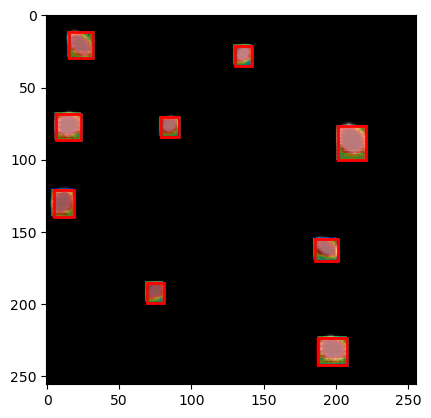

In [19]:
#Visualize whether the model can segment the test image
for data in test_loader:
    
    images = data[0].to(device)  # Extract and send image tensor to the device
    targets = data[1]

    with torch.no_grad():
        predictions = model(images)
    
    # Visualize the first image and its predictions
    visualize_prediction(images[0], predictions[0])
    #visualize_prediction(images[0], targets)


In [31]:
# Evaluate the model by calculating IoU of the predicted box and labeled image box. 
# IoU calculated how much is the box overlap between prediction and ground-truth

import numpy as np
import torch

import numpy as np
import torch

def calculate_iou(box1, box2):
    # Ensure the boxes are in the correct format
    if isinstance(box1, torch.Tensor):
        box1 = box1.detach().cpu().numpy()
    if isinstance(box2, torch.Tensor):
        box2 = box2.detach().cpu().numpy()

    # Convert to lists if necessary
    box1 = box1.tolist() if isinstance(box1, np.ndarray) else box1
    box2 = box2.tolist() if isinstance(box2, np.ndarray) else box2

    # Initialize lists to store IoUs
    ious = []

    # Calculate IoU for each pair of boxes
    for b1 in box1:
        for b2 in box2:
            # Calculate the coordinates of the intersection rectangle
            x1_inter = max(b1[0], b2[0])
            y1_inter = max(b1[1], b2[1])
            x2_inter = min(b1[2], b2[2])
            y2_inter = min(b1[3], b2[3])
            
            # Calculate intersection area
            intersection_width = max(0, x2_inter - x1_inter)
            intersection_height = max(0, y2_inter - y1_inter)
            intersection_area = intersection_width * intersection_height
            
            # Calculate area of both boxes
            box1_area = (b1[2] - b1[0]) * (b1[3] - b1[1])
            box2_area = (b2[2] - b2[0]) * (b2[3] - b2[1])
            
            # Calculate union area
            union_area = box1_area + box2_area - intersection_area
            
            # Calculate IoU
            iou = intersection_area / union_area if union_area > 0 else 0
            ious.append(iou)
    
    return ious  # Returns a list of IoUs for each box pair

gt_boxes = targets['boxes'][0]
predicted_boxes = predictions[0]['boxes']

IoUs = calculate_iou(predicted_boxes, gt_boxes)
#print("IoUs:", iou)
# Filter out zero IoUs
non_zero_ious = [iou for iou in IoUs if iou > 0]

# Calculate the final IoU as the average of non-zero IoUs
final_iou = np.mean(non_zero_ious) if non_zero_ious else 0.0

print(f"Final IoU: {final_iou}")

Final IoU: 0.8011954947325622


In [70]:
# Calculate the IoU for predicted mask and ground truth mask

import numpy as np

def calculate_mask_iou(pred_mask, gt_mask):
    """
    Calculate IoU for binary masks.

    Parameters:
    pred_mask (numpy.ndarray or torch.Tensor): Predicted binary mask.
    gt_mask (numpy.ndarray or torch.Tensor): Ground truth binary mask.

    Returns:
    float: IoU value between the two masks.
    """
    # Ensure masks are in numpy arrays (if they're PyTorch tensors)
    if isinstance(pred_mask, torch.Tensor):
        pred_mask = pred_mask.cpu().numpy()
    if isinstance(gt_mask, torch.Tensor):
        gt_mask = gt_mask.cpu().numpy()

    # Convert masks to binary (0 or 1)
    pred_mask = (pred_mask > 0).astype(np.uint8)
    gt_mask = (gt_mask > 0).astype(np.uint8)

    # Calculate intersection and union
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()

    # If union is zero, set IoU to 1 (perfect overlap)
    if union == 0:
        return 1.0

    # Compute IoU
    iou = intersection / union
    return iou

gt_masks = targets['masks'][0]
gt_mask = np.squeeze(gt_mask)  # Removes the extra dimension

predicted_masks = predictions[0]['masks']

iou_value = calculate_mask_iou(pred_mask, gt_mask)
print(f"IoU for the masks: {iou_value:.4f}")


IoU for the masks: 0.4420
